In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-03-30 13:49:04.523572: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 13:49:04.524262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 13:49:04.526353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 13:49:04.531940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743317344.541211   11377 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743317344.54

In [4]:


# Định nghĩa mã cổ phiếu và khoảng thời gian lấy dữ liệu
ma_cophieu = "APG.VN"
khoang_thoi_gian = "60d"  # Lấy dữ liệu trong 60 ngày gần nhất
buoc_thoi_gian = "5m"     # Khoảng thời gian 5 phút

# Tải dữ liệu từ Yahoo Finance
data = yf.download(ma_cophieu, period=khoang_thoi_gian, interval=buoc_thoi_gian)

# Kiểm tra dữ liệu
print(data.head())



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price                       Close    High     Low    Open Volume
Ticker                     APG.VN  APG.VN  APG.VN  APG.VN APG.VN
Datetime                                                        
2025-01-06 02:15:00+00:00  6540.0  6550.0  6540.0  6540.0   5000
2025-01-06 02:20:00+00:00  6540.0  6560.0  6540.0  6550.0  27600
2025-01-06 02:25:00+00:00  6410.0  6540.0  6410.0  6540.0  29200
2025-01-06 02:30:00+00:00  6490.0  6490.0  6410.0  6410.0   5300
2025-01-06 02:35:00+00:00  6420.0  6470.0  6420.0  6470.0   9200


In [7]:


# Lựa chọn cột giá đóng cửa và loại bỏ các giá trị NaN
data = data[['Close']].dropna()

# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Hàm tạo tập dữ liệu theo định dạng phù hợp cho LSTM
def create_dataset(dataset, time_step=30):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Tạo tập huấn luyện và kiểm tra
time_step = 30  # Sử dụng 30 khoảng thời gian trước đó để dự đoán
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape dữ liệu để phù hợp với đầu vào của LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [9]:
# Khởi tạo mô hình LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.3),
    LSTM(units=50, return_sequences=True),
    Dropout(0.3),
    LSTM(units=50),
    Dropout(0.3),
    Dense(units=1)
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Thiết lập hàm dừng sớm để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=30,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200


2025-03-30 13:49:13.411362: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/levanhuy/development/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0386 - val_loss: 7.7671e-04
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0042 - val_loss: 6.8015e-04
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0025 - val_loss: 5.5590e-04
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027 - val_loss: 9.1369e-04
Epoch 12/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


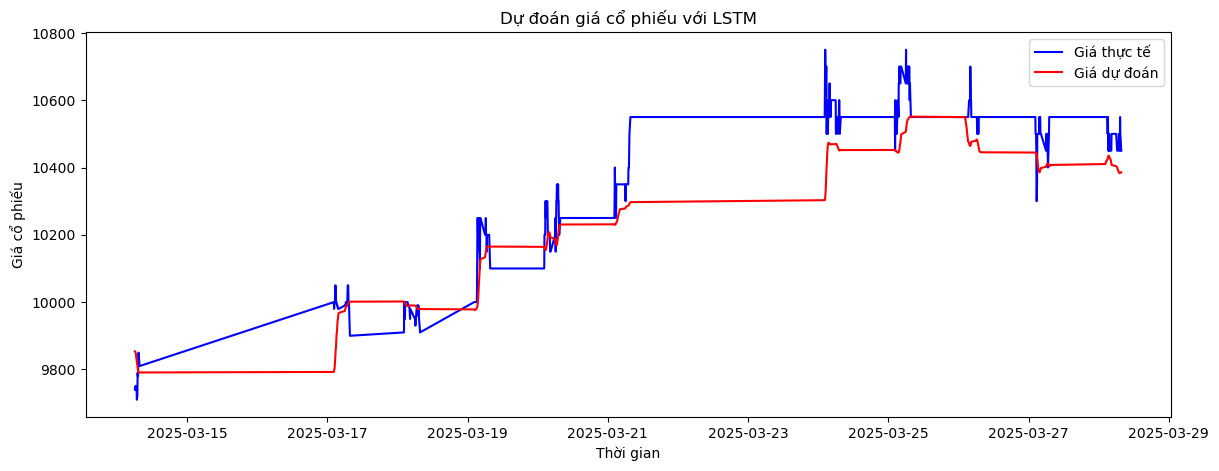

In [11]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đưa dữ liệu dự đoán và thực tế về giá trị gốc
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size + time_step:], y_test_inv, color='blue', label='Giá thực tế')
plt.plot(data.index[train_size + time_step:], y_pred_inv, color='red', label='Giá dự đoán')
plt.title('Dự đoán giá cổ phiếu với LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()

In [15]:
model.save('predict_APG_1d.keras')